In [450]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import bambi
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy
from statsmodels.regression import linear_model

## Causal Thinking

Is there a statistical procedure that mimics randomization?

P(Y|do(X)) = P(Y|**?**)

If it does, we may be able to find it in the causal model

In the simple confound model (X -> Y, with U -> X & Y) The distribution of Y, stratified by X and U, averaged over the distribution of Y is P(Y|do(X))

The causal effect of X on Y is not the coefficient relating X to Y. It is the distribution of Y when we change X, averaged over the distributions of the control variables (U). 

## Do-Calculus

Determine what is possible to say before picking functions

Justifies graphical analysis 

**Worst Case**: Additional assumptions often allow stronger inference

**Best Case**: If inference possible by do-calculus, does not depend on special assumptions

## Backdoor Criterion

Graphical/eyeeball application of do-calculus 

Rule to find a set of variablees to stratify by to yyield (PY|do(X))

1) Identify all paths connecting the treatment (X) to outcome (Y)

2) Paths with arrows entering X are backdoor paths (non-causal paths)

3) Find adjustment set that closes/blocks all backdoor paths

When you run a linear regression, the reg is a device to stratify by variables. 

In [8]:
# Confounded Y
N = 200
b_XY = 0 #No effect of X on Y, trying to infer this
b_UY = -1
b_UZ = -1
b_ZX = 1
U = np.random.binomial(1,0.5,N)
Z = np.random.normal(b_ZX*U,N)
X = np.random.normal(b_ZX*Z,N)
Y = np.random.normal(b_XY*X +b_UY*U,N)
d = pd.DataFrame.from_dict({'X':X,'Y':Y,'Z':Z})
d

,X,Y,Z
0,-40.944316,-29.395789,139.094426
1,550.185430,458.053195,395.712424
2,80.725816,164.864771,93.445162
3,120.925769,-161.894655,98.939857
4,128.696821,341.959389,132.091771
...,...,...,...
195,76.941990,324.019087,-180.484060
196,85.490462,-106.692452,365.856054
197,-22.784607,48.909461,14.156927
198,-286.854101,57.091691,-58.320119


In [9]:
# Ignore U,Z
with pm.Model() as YX_model:
    sigma = pm.Exponential('sigma',1)
    b_XY  = pm.Normal('b_XY',0,1)
    a     = pm.Normal('a',0,1)
    mu    = pm.Deterministic('mu',a + b_XY*d['X'])
    
    Y     = pm.Normal('Y',mu,sigma, observed = d['Y'])
    YX_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
G:\Statistical_Rethinking\rethinking\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [12]:
az.summary(YX_trace)[:3]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_XY,0.049,0.037,-0.018,0.116,0.000,0.000,6042.0,3092.0,1.0
a,-0.038,0.985,-1.856,1.802,0.012,0.015,6929.0,3023.0,1.0
sigma,140.726,4.871,131.701,149.827,0.062,0.044,6078.0,3130.0,1.0


In [13]:
# Stratify by Z
with pm.Model() as YXZ_model:
    sigma = pm.Exponential('sigma',1)
    b_XY  = pm.Normal('b_XY',0,1)
    b_Z   = pm.Normal('b_Z',0,1)
    a     = pm.Normal('a',0,1)
    mu    = pm.Deterministic('mu',a + b_XY*d['X'] + b_Z*d['Z'])
    
    Y     = pm.Normal('Y',mu,sigma, observed = d['Y'])
    YXZ_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_XY, b_Z, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [15]:
az.summary(YXZ_trace)[:4]
#Coefficient of Z means nothing!! 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_XY,0.012,0.048,-0.076,0.107,0.001,0.001,3113.0,2533.0,1.0
b_Z,0.079,0.069,-0.050,0.208,0.001,0.001,3082.0,2664.0,1.0
a,-0.053,1.018,-1.869,1.981,0.017,0.016,3584.0,2713.0,1.0
sigma,140.794,5.111,131.195,150.339,0.083,0.059,3781.0,2736.0,1.0


In [17]:
az.summary(YX_trace)[:3]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_XY,0.049,0.037,-0.018,0.116,0.000,0.000,6042.0,3092.0,1.0
a,-0.038,0.985,-1.856,1.802,0.012,0.015,6929.0,3023.0,1.0
sigma,140.726,4.871,131.701,149.827,0.062,0.044,6078.0,3130.0,1.0


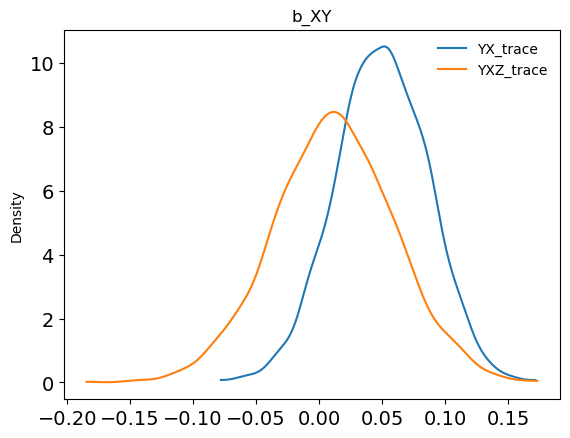

In [45]:
az.plot_dist(YX_trace.posterior['b_XY'], color='C0', label='YX_trace')
az.plot_dist(YXZ_trace.posterior['b_XY'], color='C1', label='YXZ_trace')
plt.ylabel('Density')
plt.title('b_XY')
plt.legend(frameon=False)

Very narrow set of research questions where you can get proper causal estimate with a multiple regression.

Often need to use multiple simultaneous equations. 

In [534]:
def densim(n=100,bXZ=1,bZY=1):
    X = np.random.normal(size=n)
    u = np.random.normal(size=n)
    Z = np.random.normal((bXZ*X + u),size=n)
    Y = np.random.normal((bZY*Z + u),size=n)
    data = {'Z':Z,'X':X,'Y':Y}
    
    Xmod  = linear_model.OLS.from_formula('Y ~ X',data=data)
    XZmod = linear_model.OLS.from_formula('Y ~ X + Z',
                                          data = data)
    
    bX  =  Xmod.fit().params['X']
    bXZ = XZmod.fit().params['X']
    return [bX,bXZ]
densim()

[0.6587146527223295, -0.7788044214469045]

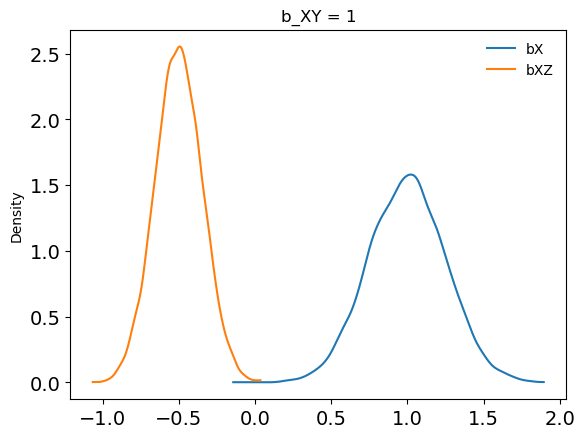

In [535]:
sim = np.array([densim(bZY=1) for x in range(10000)])
az.plot_dist(sim[:,0], color='C0', label='bX')
az.plot_dist(sim[:,1], color='C1', label='bXZ')
plt.ylabel('Density')
plt.title('b_XY = 1')
plt.legend(frameon=False)

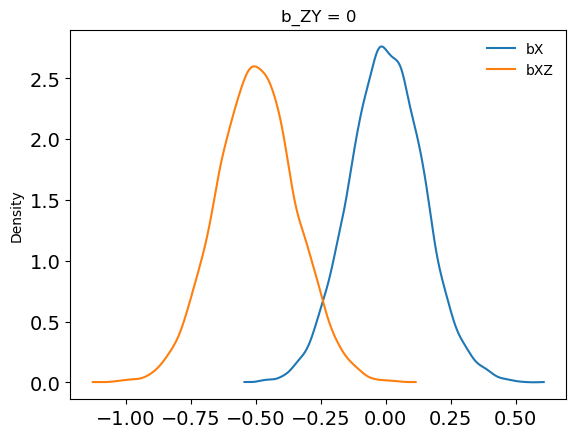

In [536]:
sim = np.array([densim(bZY=0) for x in range(10000)])
az.plot_dist(sim[:,0], color='C0', label='bX')
az.plot_dist(sim[:,1], color='C1', label='bXZ')
plt.ylabel('Density')
plt.title('b_ZY = 0')
plt.legend(frameon=False)

#Note how they overlap now! 

## Case-control bias

Sample selection on outcome.

X->-Y->Z (Y is of interest, **DO NOT STRATIFY BY Z**)

Weakly stratifying by y, most powerful way to ruin scientific inference. Reduces variation that X could explain, the association between X and Y is only observed within each level of Z

In [530]:
def cc_sim(n=100,bXY=1,bYZ=1):
    X = np.random.normal(size=n)
    Y = np.random.normal(bXY*X,size=n)
    Z = np.random.normal(bYZ*Y,size=n)
    data = {'Z':Z,'X':X,'Y':Y}
    
    Xmod  = linear_model.OLS.from_formula('Y ~ X',data=data)
    XZmod = linear_model.OLS.from_formula('Y ~ X + Z',
                                          data = data)
    
    bX  =  Xmod.fit().params['X']
    bXZ = XZmod.fit().params['X']
    return [bX,bXZ]
cc_sim()

[0.9249355429302378, 0.5848876871310605]

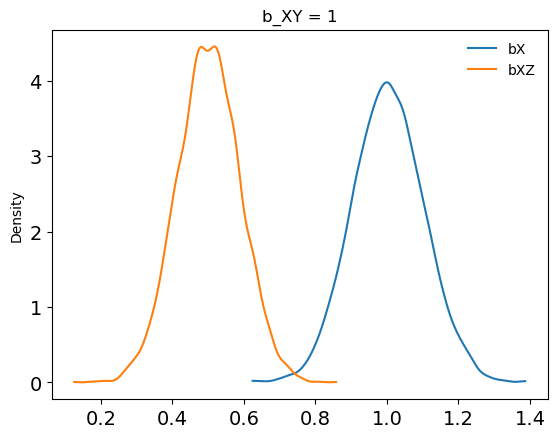

In [532]:
sim = np.array([cc_sim() for x in range(10000)])
az.plot_dist(sim[:,0], color='C0', label='bX')
az.plot_dist(sim[:,1], color='C1', label='bXZ')
plt.ylabel('Density')
plt.title('b_XY = 1')
plt.legend(frameon=False)
# Note smaller effect when stratifying by Z, this is bad!

## Precision Parasite

Z -> X -> Y (Y of interest, **No reason to stratify by Z**)

No backdoors

Not a good idea to condition on Z, not destructive, will reduce precision. 

In [528]:
def pp_sim(n=100,bZX=1,bXY=1):
    Z = np.random.normal(size=n)
    X = np.random.normal(bZX*Z,size=n)
    Y = np.random.normal(bXY*X,size=n)
    data = {'Z':Z,'X':X,'Y':Y}
    
    Xmod  = linear_model.OLS.from_formula('Y ~ X',data=data)
    XZmod = linear_model.OLS.from_formula('Y ~ X + Z',data = data)
    
    bX  =  Xmod.fit().params['X']
    bXZ = XZmod.fit().params['X']
    return([bX,bXZ])
pp_sim()

[0.947244525357104, 1.1100901072026486]

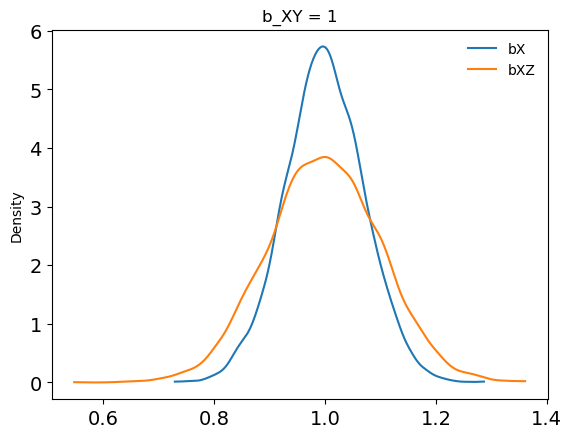

In [529]:
sim = np.array([pp_sim() for x in range(10000)])
az.plot_dist(sim[:,0], color='C0', label='bX')
az.plot_dist(sim[:,1], color='C1', label='bXZ')
plt.ylabel('Density')
plt.title('b_XY = 1')
plt.legend(frameon=False)

# Precision parasite in action, bX is correct, bXZ is less
# precise

## Bias Amplification

X and Y confounded by u

Very bad to stratify by Z as well. Double activates the confound

Covariation X & Y requires variation in their causes

X can't vary if its causes don't vary. 

Within each level of Z, less variation of X, less variation in Y. This leads to the confound (u) being relatively more important within each level of Z.

In [526]:
def ba_sim(n = 100,bZX=1,bXY=1):
    Z = np.random.normal(size = n)
    u = np.random.normal(size = n)
    X = np.random.normal(bZX*Z + u , size = n)
    Y = np.random.normal(bXY*X + u , size = n)
    data = {'Z':Z,'X':X,'Y':Y}
    
    Xmod  = linear_model.OLS.from_formula('Y ~ X',data=data)
    XZmod = linear_model.OLS.from_formula('Y ~ X + Z',data = data)
    
    bX  =  Xmod.fit().params['X']
    bXZ = XZmod.fit().params['X']
    return([bX,bXZ])
ba_sim()

[1.2677874585296744, 1.4318857018384543]

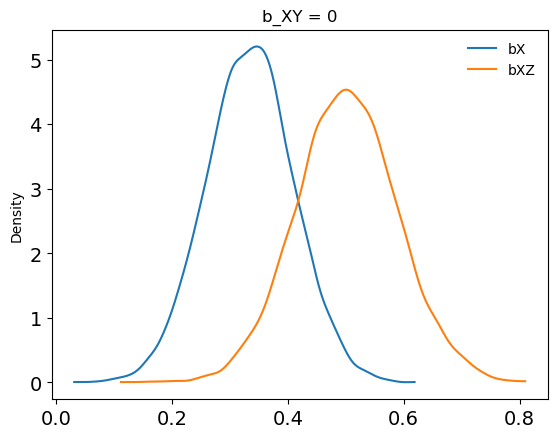

In [527]:
sim = np.array([ba_sim(bXY=0) for x in range(10000)])
az.plot_dist(sim[:,0], color='C0', label='bX')
az.plot_dist(sim[:,1], color='C1', label='bXZ')
plt.ylabel('Density')
plt.title('b_XY = 0')
plt.legend(frameon=False)
#True value is Z, bX is biased, bXZ IS MORE BIASED!

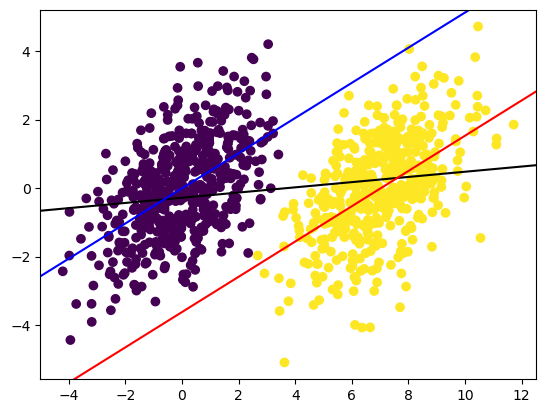

In [540]:
n = 1000
Z = np.random.binomial(1,0.5,size=n)
u = np.random.normal(size=n)
X = np.random.normal(7*Z+u,size=n)
Y = np.random.normal(0*X+u,size=n) #No causal effect

plt.scatter(X,Y,c=Z)

#Total Sample
m, b = np.polyfit(X, Y, deg=1) #Can also use stats.linregress(X,Y) or whatever else
plt.axline(xy1=(0, b), slope=m, c = 'black')

#Stratified by Z 
m0, b0 = np.polyfit(X[Z==0], Y[Z==0],deg=1)
plt.axline(xy1=(0,b0), slope=m0, c = 'blue')

m1, b1 = np.polyfit(X[Z==1], Y[Z==1],deg=1)
plt.axline(xy1=(0,b1), slope=m1, c='red')

Want the black line in the graph above. Notice the bias introduced by stratifying by z. 